Lessons learned the hard-way:
* A hyphen is not alpha-numeric. If you use `.isalpha()` on a word, which contains a hyphen, it will return False. I managed to filter out a lot of my most important vocabulary with this :( 
* `CountVectorizer` by default removes all punctuation and deletes single characters. Removing all punctuation means it will also split up all hyphenated words into two words. 

## Analysis

In [69]:
from latex2wordcloud.LaTeXStripper import strip_text

from ipywidgets import FileUpload

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import plotly.express as px
import pandas as pd

from typing import List
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag
import re

In [111]:
universal_tags_to_wordnet = {'NOUN': 'n', 'VERB': 'v', 'ADJ': 'a', 'ADV': 'r'}
wordnet_to_universal_tags = {v: k for k, v in universal_tags_to_wordnet.items()}

"""Map universal POS tags to WordNet POS tags.
  
Wordnet has five tags:
n - NOUN 
v - VERB 
a - ADJECTIVE 
s - ADJECTIVE SATELLITE 
r - ADVERB
    
Ignore the 's' tag.
"""


def lemmatize_universal_tagged_token(tagged_token, lemmatizer=WordNetLemmatizer()):
    wordnet_tag = universal_tags_to_wordnet.get(tagged_token[1], 'undefined')
    if wordnet_tag == 'undefined':
        return (lemmatizer.lemmatize(tagged_token[0]), wordnet_tag)
    else:
        return (lemmatizer.lemmatize(tagged_token[0], wordnet_tag), wordnet_tag)

def tokenize_text(text):
    return pos_tag(word_tokenize(text), tagset='universal')

def lemmatize_tokens(tokens):
    return [lemmatize_universal_tagged_token(token) for token in tokens]

def convert_tokens_to_lowercase(tokens):
    return [(token[0].lower().strip(), token[1]) for token in tokens]

def filter_stopwords(tokens, stopwords):
    return [token for token in tokens if token[0] not in stopwords]

def keep_only_specified_tags(tokens, tag_list):
    return [token for token in tokens if token[1] in tag_list]

def delete_punctuation_from_tokens(tokens):
    """Delete punctuation but keep hyphens. Filter out punctuation tokens."""
    punctuation_without_hyphen = re.sub('-', '', string.punctuation)
    return [(token[0].translate(str.maketrans('', '', punctuation_without_hyphen)), token[1])
            for token in tokens
            if re.sub('^\W*', '', token[0])]

def split_hyphenated_tokens(tokens):
    return [(token_p, token[1])
            for token in tokens
            for token_p in token[0].split('-')]

def convert_text_to_clean_tokens(text, clean_latex=False, lemmatize=False, stopwords=None, taglist=None, delete_punctuation=False, split_hyphenation=False):
    if clean_latex:
        text = strip_text(text)
    
    tokens = tokenize_text(text)
    
    if lemmatize:
        tokens = lemmatize_tokens(tokens)
    
    tokens = convert_tokens_to_lowercase(tokens)
    
    if stopwords:
        tokens = filter_stopwords(tokens, stopwords)
    
    if taglist:
        tokens = keep_only_specified_tags(tokens, taglist)
    
    if delete_punctuation:
        tokens = delete_punctuation_from_tokens(tokens)
        
    if split_hyphenation:
        tokens = split_hyphenated_tokens(tokens)
        
    return tokens

In [3]:
def is_latex(string):
    if string in ['end', 'begin', 'eq', 'mathscr', 'rangle', 'equation', 'frac', 'equation', 'left', 'right', 'label',
                 'ref', 'eqnarray', 'cite', 'fig', 'figure', 'section', 'sec', 'eqref']:
        return 'LaTeX'
    else:
        return 'Other'
    
def is_latex_math_or_text(string):
    latex = is_latex(string)
    if latex == 'LaTeX':
        return latex
    elif string in ['omega', 'omega_', 'hat', 'd_', 'd', 'bar', 'tau', 'psi', 'pi', 'phi', 'sin', 'varphi']:
        return 'Math'
    else:
        return 'Text'

In [104]:
def create_wordcounts_text(text):
    # CountVectorizer stop_words problematic, see: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
    #cv_raw = CountVectorizer(min_df=0, stop_words='english', max_features=50)
    cv_raw = CountVectorizer(min_df=0, max_features=50)
    counts_raw = cv_raw.fit_transform([text])

    wordcounts = []
    for word, count in zip(cv_raw.get_feature_names_out(), counts_raw.toarray()[0]):
        wordcounts.append({'word': word, 'count': count})
    df_wordcounts = pd.DataFrame(wordcounts)
    df_wordcounts['is_latex'] = df_wordcounts['word'].map(lambda x: is_latex(x))
    df_wordcounts['TextType'] = df_wordcounts['word'].map(lambda x: is_latex_math_or_text(x))
    return df_wordcounts

def create_wordcounts_bar_chart(wordcounts: pd.DataFrame, top=50, color_by='TextType') -> None:
    # TODO: Fix this top to actually show the top ... entries
    fig = px.bar(wordcounts.nlargest(top, 'total_count'), x='word', y='count', color=color_by)
    fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
    fig.show()

In [116]:
def create_wordcounts(tokens):
    df = pd.DataFrame([{'word': token[0], 'pos_tag':token[1]} for token in tokens])
    df = df.groupby(['word', 'pos_tag'], as_index=False).size().rename(columns={'size': 'count'})
    df['total_count'] = df.groupby('word')['count'].transform(lambda x: x.sum())
    df['TextType'] = df['word'].map(lambda x: is_latex_math_or_text(x))
    df['pos_tag'] = df['pos_tag'].map(lambda x: wordnet_to_universal_tags.get(x, 'other'))
    return df

In [6]:
uploader = FileUpload(multiple=False)
display(uploader)

FileUpload(value={}, description='Upload')

In [7]:
text_raw = uploader.data[0].decode("utf-8")

In [17]:
create_wordcounts_bar_chart(create_wordcounts_text(text_raw))

In [18]:
text_clean = ' '.join([token[0] for token in convert_text_to_clean_tokens(text_raw, stopwords=stopwords.words('english'))])
create_wordcounts_bar_chart(create_wordcounts_text(text_clean))

In [19]:
text_clean = ' '.join([token[0] for token in convert_text_to_clean_tokens(text_raw,
                                                                          stopwords=stopwords.words('english'),
                                                                         clean_latex=True)])
create_wordcounts_bar_chart(create_wordcounts_text(text_clean))

Your text originally contained 76157 words, 31713 of which were stripped off.


In [46]:
tokens = convert_text_to_clean_tokens(text_raw, stopwords=stopwords.words('english'),
                                                                         clean_latex=True,
                                                                         lemmatize=True)
text_clean = ' '.join([token[0] for token in tokens])
create_wordcounts_bar_chart(create_wordcounts_text(text_clean))

Your text originally contained 76157 words, 31713 of which were stripped off.


In [72]:
tokens = convert_text_to_clean_tokens(text_raw, stopwords=stopwords.words('english'),
                                                                         clean_latex=True,
                                                                         lemmatize=True,
                                     delete_punctuation=True)
text_clean = ' '.join([token[0] for token in tokens])
create_wordcounts_bar_chart(create_wordcounts_text(text_clean))

Your text originally contained 76157 words, 31713 of which were stripped off.


In [86]:
tokens = convert_text_to_clean_tokens(text_raw, stopwords=stopwords.words('english'),
                                                                         clean_latex=True,
                                                                         lemmatize=True,
                                     delete_punctuation=True,
                                      split_hyphenation=True)
text_clean = ' '.join([token[0] for token in tokens])
create_wordcounts_bar_chart(create_wordcounts_text(text_clean))

Your text originally contained 76157 words, 31713 of which were stripped off.


In [117]:
create_wordcounts_bar_chart(create_wordcounts(tokens), top=80, color_by='pos_tag')

In [130]:
from wordcloud import WordCloud

def make_wordcloud(words_cleaned: pd.DataFrame, filename=None):
    wordcloud = WordCloud().generate_from_frequencies(words_cleaned[['word', 'total_count']].drop_duplicates().set_index('word').to_dict()['total_count'])
    
    if filename:
       wordcloud.to_file(filename) 

    display(wordcloud.to_image().resize((800, 400)))

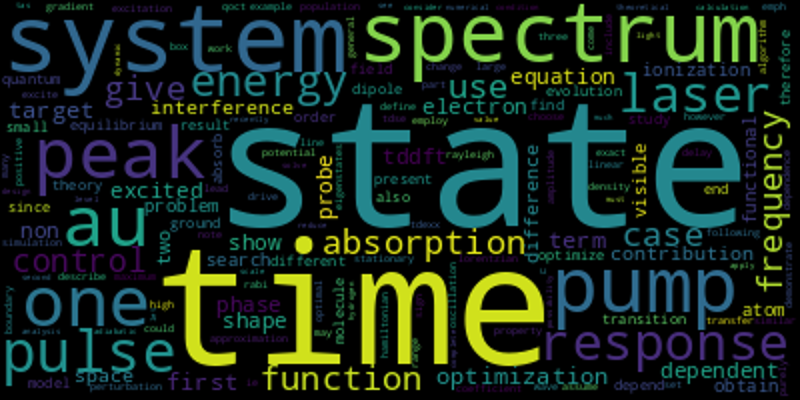

In [131]:
make_wordcloud(create_wordcounts(tokens))